# Transfer learning (domain adaptation)

Once the domain shift between phase 1 and phase 2 populations has been identified, let us jump to domain adaptation. Several techniques will be implemented:

1. Semi-supervised learning (use of the small subset of labelled data for learning)
2. Self-supervised learning (use model of phase 1 to label the data of phase 2)
3. Unsupervised domain adaptation (align phase 1 and phase 2 distributions in a common latent space)

(Some other approaches to face domain shift: 
- Domain Adversarial Training: Here, models are trained to have representations which cannot be easily distinguished between source and target using a domain discriminator.
- Subspace Alignment: Methods like CORrelation ALignment (CORAL) minimize domain shift by aligning the second-order statistics (covariance) of source and target features.
- Instance Re-weighting: Source instances are re-weighted based on their similarity to the target domain.
- Fine-tuning: After pre-training a model on the source domain, it is fine-tuned on a small labeled dataset from the target domain.)

In [27]:
import os
import numpy as np
import pandas as pd
import importlib
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc, accuracy_score, precision_score, recall_score
import prince

# import from custom package
from auxFuns.EDA import *
from auxFuns.modelling import *
from auxFuns.class_overlap import *
from auxFuns.transfer_learning import *

In [5]:
import auxFuns.EDA 
importlib.reload(auxFuns.EDA)

import auxFuns.modelling
importlib.reload(auxFuns.modelling)

import auxFuns.class_overlap
importlib.reload(auxFuns.class_overlap)

import auxFuns.transfer_learning
importlib.reload(auxFuns.transfer_learning)

<module 'auxFuns.transfer_learning' from 'c:\\Users\\angel\\Documents\\VSCode\\rsv_modelling_transfer_learning\\auxFuns\\transfer_learning.py'>

## Loading of data and dataframes preparation

In [4]:
# Load of the data and filter in the needed features

raw_datasets_path = os.getcwd() + '/datasets/raw'
processed_datasets_path = os.getcwd() + '/datasets/processed'

# Phase 1 data
rsv_predictors_df_v2 = pd.read_csv(processed_datasets_path + '/rsv_predictors_phase1_daysDedup_seasons_prevTest_v2.csv',low_memory=False)
rsv_predictors_phase1_df = make_it_categorical_v2(rsv_predictors_df_v2)

# Phase 2 data
rsv_phase2_df = pd.read_csv(processed_datasets_path + '/rsv_phase2_all_features.csv',low_memory=False)
rsv_phase2_df = make_it_categorical_v2(rsv_phase2_df, is_phase1 = False)

# Small subset of labelled data of phase 2:
labels_phase2_df = pd.read_csv(raw_datasets_path + '/rsv_test_phase2.csv',low_memory=False)
labels_phase2_df = labels_phase2_df.rename(columns = {'RSV_test_date':'index_date'})

# Compatibility issue detected: merging labelled and unlabelled data is challening due to incompatible date columns
rsv_phase2_df.index_date = pd.to_datetime(rsv_phase2_df.index_date)
labels_phase2_df.index_date = pd.to_datetime(labels_phase2_df.index_date)

rsv_phase2_labelled_df = labels_phase2_df.merge(rsv_phase2_df, how='left', on=['patient_id', 'index_date'])
# rsv_phase2_labelled_df = labels_phase2_df.merge(rsv_phase2_df, how='left', on=['patient_id'])
rsv_phase2_labelled_df = rsv_phase2_labelled_df.dropna()

rsv_predictors_phase1_df.shape, rsv_phase2_df.shape, rsv_phase2_labelled_df.shape

((86058, 64), (291938, 63), (2867, 64))

In [5]:
# Only 2003 of the 3073 (~65%) patients who underwent a RSV test are present in the whole populations's dataset
patient_ids_rsv_test = labels_phase2_df.patient_id.unique()
patient_ids_phase2 = rsv_phase2_df.patient_id.unique()

len(patient_ids_rsv_test), len(patient_ids_phase2), (pd.Series(patient_ids_rsv_test).isin(patient_ids_phase2)).sum()

(3073, 40507, 2003)

In [6]:
selected_features = ['sex', 'marital_status', 'race','patient_regional_location', 'age_group',
                     'Acute_upper_respiratory_infection','Influenza','Pneumonia','Bronchitis','Symptoms_and_signs__digestive_system_and_abdomen','General_symptoms_and_signs','any_symptom',
                     'COPD','AIDS','Asthma_chronic','CCI',
                     'sine','cosine','calendar_year', 
                     'healthcare_seeking', 'influenza_vaccine',
                     'n_symptoms','prev_positive_rsv','previous_test_daydiff','n_immunodeficiencies', 
                     'tumor_indicator','tumor_last_year',
                     'season',
                     'n_tests_that_day']
selected_features_v1 = ['n_tests_that_day', 'sine','cosine', 'previous_test_daydiff',
                     'Bronchitis', 'CCI',
                     'Acute_upper_respiratory_infection', 'n_immunodeficiencies', 'n_symptoms',
                     'healthcare_seeking', 
                     'General_symptoms_and_signs', 'prev_positive_rsv', 'Influenza',
                     'season','multiple_tests']
selected_features_v2 = ['n_tests_that_day', 'sine','cosine', 'previous_test_daydiff',
                     'Bronchitis', 'CCI',
                     'Acute_upper_respiratory_infection', 'n_immunodeficiencies', 'n_symptoms',
                     'healthcare_seeking', 
                     'General_symptoms_and_signs', 'prev_positive_rsv', 'Influenza',
                     'key_comorbidities','Pneumonia',
                     'season','month_of_the_test','multiple_tests',
                     'BPA','BPAI']
selected_features_v3 = selected_features_v2 + ['race', 'age_group','marital_status','sex',
                                                    'patient_regional_location','calendar_year']

selected_features_v2_aux = selected_features_v2.copy()
selected_features_v1.append('RSV_test_result')
selected_features_v2.append('RSV_test_result')
selected_features_v3.append('RSV_test_result')

In [7]:
df_modelling_phase1 = rsv_predictors_phase1_df[selected_features_v2]
df_modelling_phase2 = rsv_phase2_labelled_df[selected_features_v2]
df_modelling_all_phase2 = rsv_phase2_df[selected_features_v2_aux]

df_modelling_phase1.shape, df_modelling_phase2.shape, df_modelling_all_phase2.shape

((86058, 21), (2867, 21), (291938, 20))

In [9]:
# differentiate between labelled and non-labelled data in phase 2
labelled_data_phase2_mask = rsv_phase2_labelled_df.index
labelled_mask = rsv_phase2_df.index.isin(labelled_data_phase2_mask)
non_labelled_mask = ~rsv_phase2_df.index.isin(labelled_data_phase2_mask)

df_modelling_phase2_labelled = df_modelling_phase2.copy()
df_modelling_phase2_nonlabelled = df_modelling_all_phase2.loc[non_labelled_mask,:]

df_modelling_phase1.shape, df_modelling_phase2_labelled.shape, df_modelling_phase2_nonlabelled.shape

((86058, 21), (2867, 21), (289071, 20))

In [ ]:
# Ensure consistency between source and target categories
df_modelling_phase2_labelled_copy = df_modelling_phase2_labelled.copy()
df_modelling_phase2_nonlabelled_copy = df_modelling_phase2_nonlabelled.copy()

df_modelling_phase2_labelled['n_tests_that_day'] = pd.Categorical(df_modelling_phase2_labelled_copy['n_tests_that_day'], categories=[1, 2])
df_modelling_phase2_nonlabelled['n_tests_that_day'] = pd.Categorical(df_modelling_phase2_nonlabelled_copy['n_tests_that_day'], categories=[1, 2])

## 1. Semi-supervised domain adaptation

Let us start by using the small subset of labelled data of phase 2. To this end, we will evaluate the following methods:

- Re weighting of key samples
- Alignment of the latent spaces
- Domain-adversarial training
 

In [50]:
df_modelling_phase2_labelled.RSV_test_result.value_counts(), 

positives = df_modelling_phase2_labelled.RSV_test_result.value_counts()[1]
negatives = df_modelling_phase2_labelled.RSV_test_result.value_counts()[0]
p_pos = positives/(positives+negatives)
IR = negatives/positives

print(f'Number of positive samples in labelled data phase 2: {positives}')
print(f'Proportion of positive labels: {p_pos}')
print(f'Imbalance ratio of phase 2 labelled data: {IR}')
# the imbalance in this case is even heavier than in phase 1 data

Number of positive samples in labelled data phase 2: 52
Proportion of positive labels: 0.018137425880711544
Imbalance ratio of phase 2 labelled data: 54.13461538461539


In [52]:
X_source = df_modelling_phase1.drop(['RSV_test_result'], axis = 1)
labels_source = df_modelling_phase1['RSV_test_result']

X_target = df_modelling_phase2_labelled.drop(['RSV_test_result'], axis = 1)
labels_target = df_modelling_phase2_labelled['RSV_test_result']

# Define the combined population too
X_combined = pd.concat([X_source, X_target], axis = 0)
y_combined = np.hstack((np.zeros(len(X_source)), np.ones(len(X_target))))

In [34]:
# Also, visualize how the labelled data is overlapped or not
random_seed = 42
n_components = 5

famd = prince.FAMD(n_components=n_components, random_state=random_seed)
famd = famd.fit(X_combined)

df_labelled_data_visualization = famd.transform(X_combined)

# Add the phase label for visualization
df_labelled_data_visualization['phase'] = y_combined

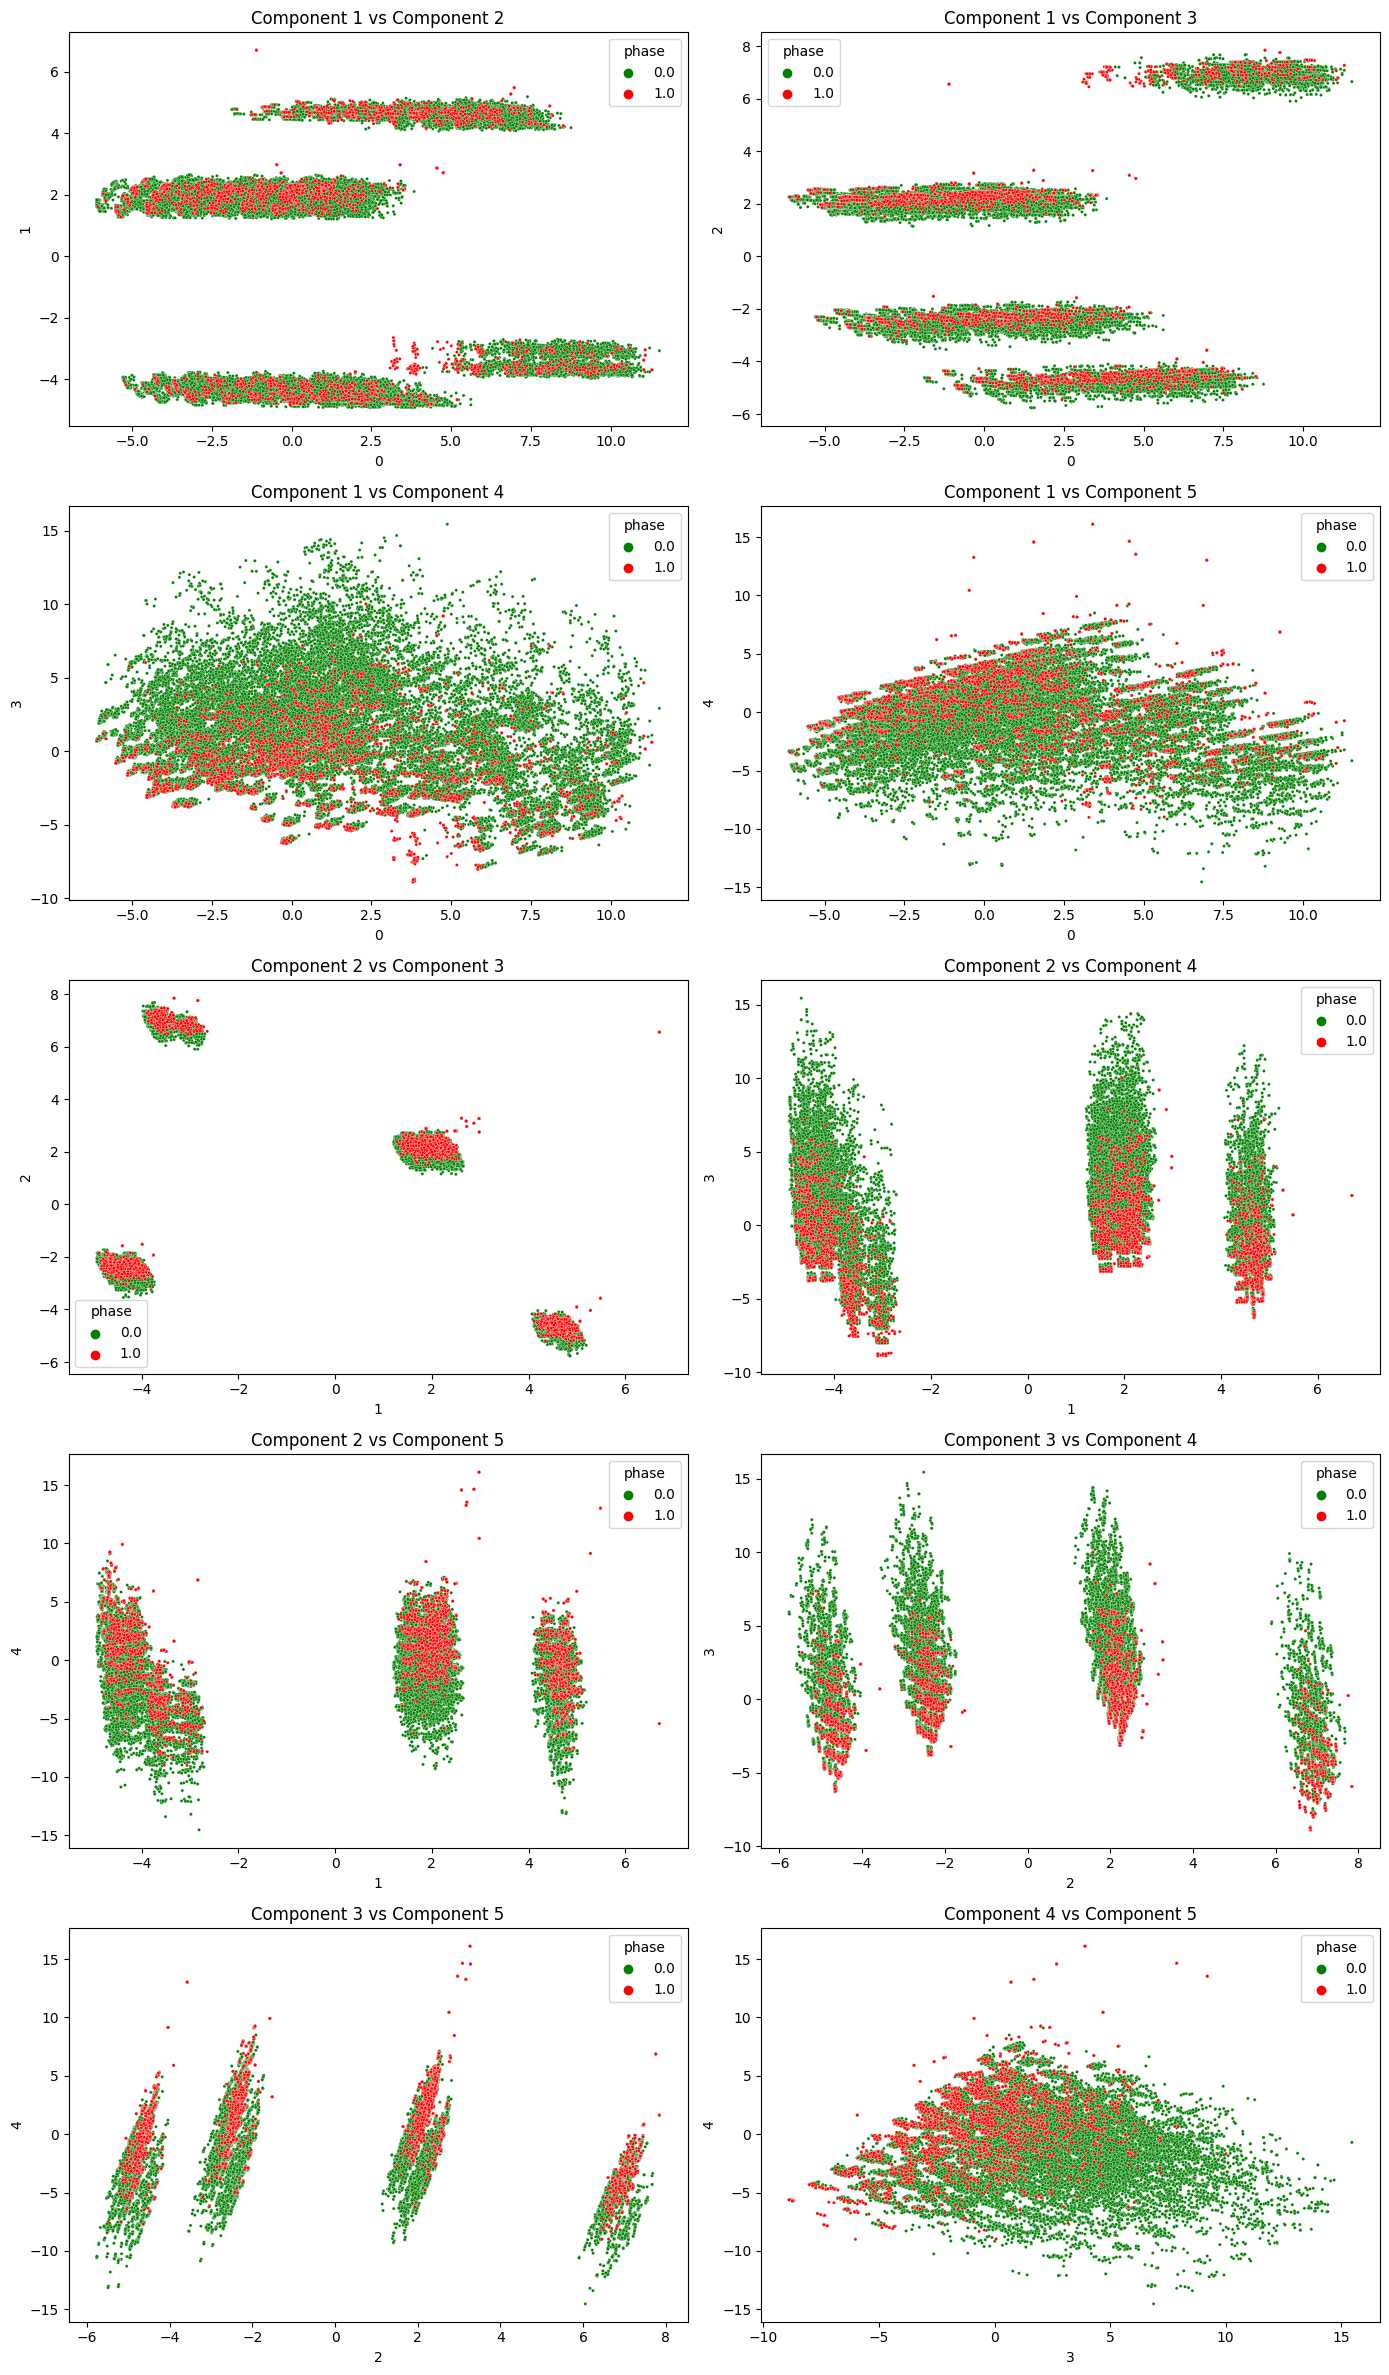

In [35]:
plot_5FMDA_planes(df = df_labelled_data_visualization, hue_target = 'phase', palette = {1: 'red', 0:'green'},s_size = 5)

These results are interesting as enable to differentiate between two clear areas of points in the source population:
- Some are clearly overlapped with phase 2 data
- Some are clearly separated

This will allow a more eficient weighting of the source instances

### Semi-supervised: instance-reweighting

Instance reweighting by itself can be challenging. We will follow the approach of using a discriminator to differentiate between phase 1 and phase 2 labelled data, and then use the prediction probabilities of that discriminator as weights.

In [99]:
X_combined.columns

Index(['n_tests_that_day', 'sine', 'cosine', 'previous_test_daydiff',
       'Bronchitis', 'CCI', 'Acute_upper_respiratory_infection',
       'n_immunodeficiencies', 'n_symptoms', 'healthcare_seeking',
       'General_symptoms_and_signs', 'prev_positive_rsv', 'Influenza',
       'key_comorbidities', 'Pneumonia', 'season', 'month_of_the_test',
       'multiple_tests', 'BPA', 'BPAI'],
      dtype='object')

In [123]:
# GOAL: 
# i) build a classifier able to differentiate between phase 1 and phase 2 data
# ii) on the same set as the training, predict the probabilities to belonging to one or the other 
# iii) assign these probabilities as weights for the instance re-weighting process

# i: train a discriminator (and see its performance)
# all the followuing hyperparameters are introduced so the random forest is not too good at memorizing the training data
discriminator = RandomForestClassifier(n_estimators=15, 
                                       max_depth=10, 
                                       min_samples_split=10, 
                                       min_samples_leaf=5, 
                                       max_features=0.5, 
                                       oob_score=True,
                                       class_weight = {0:1, 1:15}).fit(pd.get_dummies(X_combined), y_combined)
print("OOB Score:", discriminator.oob_score_)

# discriminator = LogisticRegression().fit(pd.get_dummies(X_combined), y_combined)

# Predict for all instances (X_combined) to evaluate performance
probs_performance = discriminator.predict_proba(pd.get_dummies(X_combined))[:, 1] # Probabilities for class 1 (target)
y_pred_performance = probs_performance > 0.5
accuracy_discriminator = accuracy_score(y_combined, y_pred_performance)
recall_discriminator = recall_score(y_combined, y_pred_performance)
precision_discriminator = precision_score(y_combined, y_pred_performance)

print(f'Accuracy of the discriminator is: {accuracy_discriminator}')
print(f'Recall of the discriminator is: {recall_discriminator}')
print(f'Precision of the discriminator is: {precision_discriminator}')

# ii: predict the probabilities (for source data only, as we are interested in reweighting the instances of the source population)
probs_source = discriminator.predict_proba(pd.get_dummies(X_source))[:, 1] # Probabilities for class 1 (target)


# iii: define the weights for instance reweighting
source_instances_weights = probs_source / (1 - probs_source)

C:\Users\angel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\ensemble\_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


OOB Score: 0.9709418048917627
Accuracy of the discriminator is: 0.9760697216755693
Recall of the discriminator is: 0.6557377049180327
Precision of the discriminator is: 0.6223104932141675


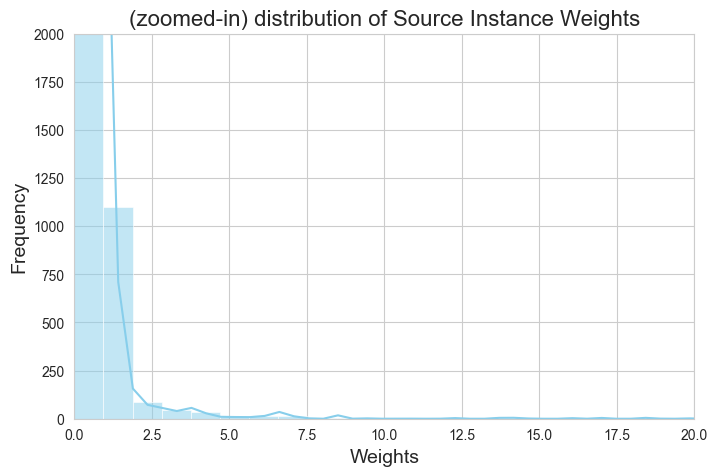

In [136]:
# Histogram for visualization of the final weights
weights = source_instances_weights[source_instances_weights >= 0]

sns.set_style("whitegrid")
sns.set_palette("muted")

plt.figure(figsize=(8,5))
sns.histplot(weights, bins=100, kde=True, color='skyblue')

plt.title('(zoomed-in) distribution of Source Instance Weights', fontsize=16)
plt.xlabel('Weights', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xlim([0,20]); plt.ylim([0,2000])
plt.show()